# **Preface** 

Maintenance of equipment is a critical activity for any business involving machines. Predictive maintenance is the method of scheduling maintenance based on the prediction about the failure time of any equipment. The machine learning models is constructed based on the datasets from turbo fan engine data from the Prognostics Data Repository of NASA. Using a training set, a model was constructed and was verified with a test data set. The results obtained were compared with the actual results to calculate the accuracy and the algorithm that results in maximum accuracy is identified. We have selected two machine learning algorithms for comparing the prediction accuracy.

In [1]:
# Importing required libraries 

import math
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set()

# **Data**

Our data includes data of 100 engines, each doing their respective number of cycles as per their functional lifecycle. During each cycle the sensors installed collects the data in each respective cycle. Based on this collected data we need to build a model which would predict the remaining useful life(**RUL**, time before which engine goes for maintenance to avoid unexpected breakdown) of a already/newly installed engine based on its current cycle data.  

In [2]:
#Importing data files

jet_data = pd.read_csv(r"E:\AI_ML_DL\PROJECT\Predictive Maintenance\CMaps\train_FD001.txt", sep=" ", header=None)
jet_rul = pd.read_csv(r"E:\AI_ML_DL\PROJECT\Predictive Maintenance\CMaps\RUL_FD001.txt", sep=" ", header=None)
test_data = pd.read_csv(r"E:\AI_ML_DL\PROJECT\Predictive Maintenance\CMaps\test_FD001.txt", sep = "\s+", header = None)
jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]
test_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21"]

In [3]:
jet_data.head()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
1   1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
2   1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
3   1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
4   1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   

   sensor5  ...  sensor14  sensor15  sensor16  sensor17  sensor18  sensor19  \
0    14.62  ...   8138.62    8.4195      0.03       392      2388     100.0   
1    14.62  ...   8131.49    8.4318      0.03       392      2388     100.0   
2    14.62  ...   8133.23    8.4178      0.03       390      2388     100.0   
3    14.62  ...   8133.83    8.3682      0.03       392      2388     100.0   
4    14.62  ...   8133.80    8.4294      0.03       393      2388     100.0   

   sensor20  sensor21  sensor22  sensor23  
0     39.06   23.4190       NaN       NaN  
1     39.00   23.4236       NaN       NaN  
2     38.95   23.3442       NaN       NaN  
3     38.88   23.3739       NaN       NaN  
4     38.90   23.4044       NaN       NaN  

[5 rows x 28 columns]

In [4]:
jet_rul.head()

0   1
0  112 NaN
1   98 NaN
2   69 NaN
3   82 NaN
4   91 NaN

In [5]:
jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

jet_rul.columns = ['cycles', 'id']
jet_rul['id'] = jet_data['id'].unique()
jet_rul.set_index('id', inplace=True)
jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()
jet_id_and_rul.set_index('id', inplace=True)

In [6]:
jet_data

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0        1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
1        1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
2        1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
3        1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
4        1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   
...    ...    ...     ...     ...    ...      ...      ...      ...      ...   
20626  100    196 -0.0004 -0.0003  100.0   518.67   643.49  1597.98  1428.63   
20627  100    197 -0.0016 -0.0005  100.0   518.67   643.54  1604.50  1433.58   
20628  100    198  0.0004  0.0000  100.0   518.67   643.42  1602.46  1428.18   
20629  100    199 -0.0011  0.0003  100.0   518.67   643.23  1605.26  1426.53   
20630  100    200 -0.0032 -0.0005  100.0   518.67   643.85  1600.38  1432.14   

       sensor5  ...  sensor12  sensor13  sensor14  sensor15  sensor16  \
0        14.62  ...    521.66   2388.02   8138.62    8.4195      0.03   
1        14.62  ...    522.28   2388.07   8131.49    8.4318      0.03   
2        14.62  ...    522.42   2388.03   8133.23    8.4178      0.03   
3        14.62  ...    522.86   2388.08   8133.83    8.3682      0.03   
4        14.62  ...    522.19   2388.04   8133.80    8.4294      0.03   
...        ...  ...       ...       ...       ...       ...       ...   
20626    14.62  ...    519.49   2388.26   8137.60    8.4956      0.03   
20627    14.62  ...    519.68   2388.22   8136.50    8.5139      0.03   
20628    14.62  ...    520.01   2388.24   8141.05    8.5646      0.03   
20629    14.62  ...    519.67   2388.23   8139.29    8.5389      0.03   
20630    14.62  ...    519.30   2388.26   8137.33    8.5036      0.03   

       sensor17  sensor18  sensor19  sensor20  sensor21  
0           392      2388     100.0     39.06   23.4190  
1           392      2388     100.0     39.00   23.4236  
2           390      2388     100.0     38.95   23.3442  
3           392      2388     100.0     38.88   23.3739  
4           393      2388     100.0     38.90   23.4044  
...         ...       ...       ...       ...       ...  
20626       397      2388     100.0     38.49   22.9735  
20627       395      2388     100.0     38.30   23.1594  
20628       398      2388     100.0     38.44   22.9333  
20629       395      2388     100.0     38.29   23.0640  
20630       396      2388     100.0     38.37   23.0522  

[20631 rows x 26 columns]

# **Data Manipulation**

The test data does not have RUL column so for model validation purposes we will add the column externally in the dataframe

In [7]:
#adding RUL column to the data
def RUL_calculator(df, df_max_cycles):
    max_cycle = df_max_cycles["cycle"]
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"] 
    result_frame.drop(['max_cycle'], axis=1, inplace=True)
    return result_frame

jet_data = RUL_calculator(jet_data, jet_id_and_rul)

In [8]:
jet_data.head()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
1   1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
2   1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
3   1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
4   1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   

   sensor5  ...  sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  \
0    14.62  ...   2388.02   8138.62    8.4195      0.03       392      2388   
1    14.62  ...   2388.07   8131.49    8.4318      0.03       392      2388   
2    14.62  ...   2388.03   8133.23    8.4178      0.03       390      2388   
3    14.62  ...   2388.08   8133.83    8.3682      0.03       392      2388   
4    14.62  ...   2388.04   8133.80    8.4294      0.03       393      2388   

   sensor19  sensor20  sensor21  RUL  
0     100.0     39.06   23.4190  191  
1     100.0     39.00   23.4236  190  
2     100.0     38.95   23.3442  189  
3     100.0     38.88   23.3739  188  
4     100.0     38.90   23.4044  187  

[5 rows x 27 columns]

In [9]:
#Preliminary analysis of data to understand the number of parameters and basic statistics
jet_data.describe()

id         cycle           op1           op2      op3  \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.0   
mean      51.506568    108.807862     -0.000009      0.000002    100.0   
std       29.227633     68.880990      0.002187      0.000293      0.0   
min        1.000000      1.000000     -0.008700     -0.000600    100.0   
25%       26.000000     52.000000     -0.001500     -0.000200    100.0   
50%       52.000000    104.000000      0.000000      0.000000    100.0   
75%       77.000000    156.000000      0.001500      0.000300    100.0   
max      100.000000    362.000000      0.008700      0.000600    100.0   

        sensor1       sensor2       sensor3       sensor4       sensor5  ...  \
count  20631.00  20631.000000  20631.000000  20631.000000  2.063100e+04  ...   
mean     518.67    642.680934   1590.523119   1408.933782  1.462000e+01  ...   
std        0.00      0.500053      6.131150      9.000605  1.776400e-15  ...   
min      518.67    641.210000   1571.040000   1382.250000  1.462000e+01  ...   
25%      518.67    642.325000   1586.260000   1402.360000  1.462000e+01  ...   
50%      518.67    642.640000   1590.100000   1408.040000  1.462000e+01  ...   
75%      518.67    643.000000   1594.380000   1414.555000  1.462000e+01  ...   
max      518.67    644.530000   1616.910000   1441.490000  1.462000e+01  ...   

           sensor13      sensor14      sensor15      sensor16      sensor17  \
count  20631.000000  20631.000000  20631.000000  2.063100e+04  20631.000000   
mean    2388.096152   8143.752722      8.442146  3.000000e-02    393.210654   
std        0.071919     19.076176      0.037505  1.387812e-17      1.548763   
min     2387.880000   8099.940000      8.324900  3.000000e-02    388.000000   
25%     2388.040000   8133.245000      8.414900  3.000000e-02    392.000000   
50%     2388.090000   8140.540000      8.438900  3.000000e-02    393.000000   
75%     2388.140000   8148.310000      8.465600  3.000000e-02    394.000000   
max     2388.560000   8293.720000      8.584800  3.000000e-02    400.000000   

       sensor18  sensor19      sensor20      sensor21           RUL  
count   20631.0   20631.0  20631.000000  20631.000000  20631.000000  
mean     2388.0     100.0     38.816271     23.289705    107.807862  
std         0.0       0.0      0.180746      0.108251     68.880990  
min      2388.0     100.0     38.140000     22.894200      0.000000  
25%      2388.0     100.0     38.700000     23.221800     51.000000  
50%      2388.0     100.0     38.830000     23.297900    103.000000  
75%      2388.0     100.0     38.950000     23.366800    155.000000  
max      2388.0     100.0     39.430000     23.618400    361.000000  

[8 rows x 27 columns]

In [10]:
#checking the RUL data values 
jet_data.tail()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
20626  100    196 -0.0004 -0.0003  100.0   518.67   643.49  1597.98  1428.63   
20627  100    197 -0.0016 -0.0005  100.0   518.67   643.54  1604.50  1433.58   
20628  100    198  0.0004  0.0000  100.0   518.67   643.42  1602.46  1428.18   
20629  100    199 -0.0011  0.0003  100.0   518.67   643.23  1605.26  1426.53   
20630  100    200 -0.0032 -0.0005  100.0   518.67   643.85  1600.38  1432.14   

       sensor5  ...  sensor13  sensor14  sensor15  sensor16  sensor17  \
20626    14.62  ...   2388.26   8137.60    8.4956      0.03       397   
20627    14.62  ...   2388.22   8136.50    8.5139      0.03       395   
20628    14.62  ...   2388.24   8141.05    8.5646      0.03       398   
20629    14.62  ...   2388.23   8139.29    8.5389      0.03       395   
20630    14.62  ...   2388.26   8137.33    8.5036      0.03       396   

       sensor18  sensor19  sensor20  sensor21  RUL  
20626      2388     100.0     38.49   22.9735    4  
20627      2388     100.0     38.30   23.1594    3  
20628      2388     100.0     38.44   22.9333    2  
20629      2388     100.0     38.29   23.0640    1  
20630      2388     100.0     38.37   23.0522    0  

[5 rows x 27 columns]

# **Visualizing Data**

We will visualize the data to determine the relevance of data and figure out the model determining attributes

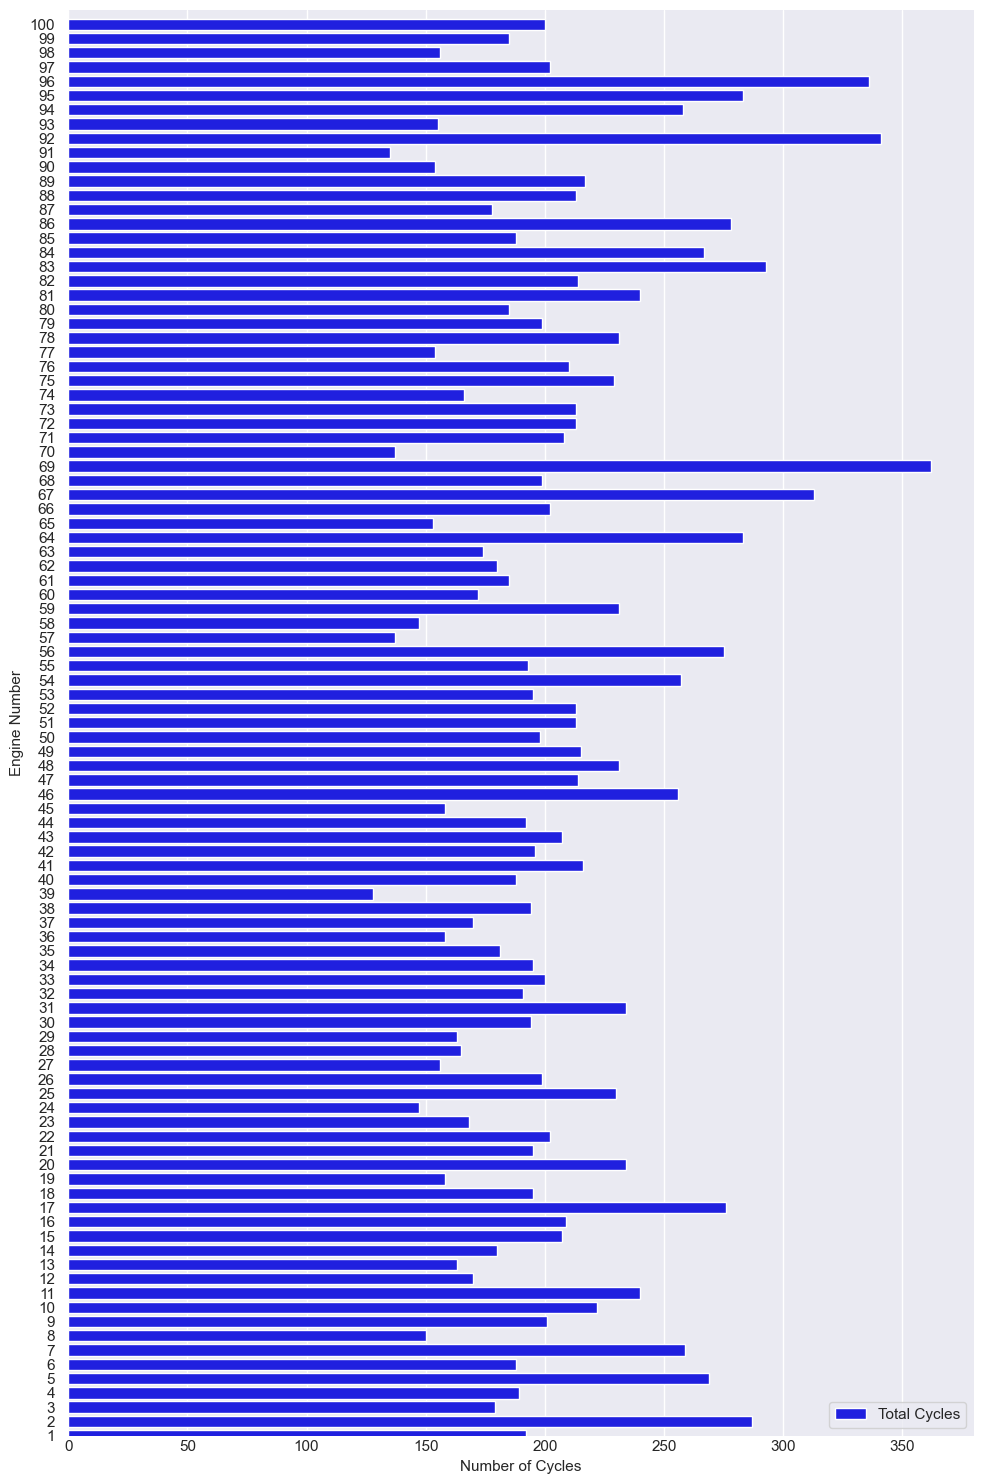

In [11]:
# Visualize total number of cycles by each engine

jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="id", data=jet_id_and_rul, label="Total Cycles", color="blue", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 100), ylabel="",xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Engine Number", fontsize=11)
ax.set_xlabel("Number of Cycles", fontsize=11)
plt.tight_layout()
plt.show()

Mean number of cycles after which jet engine fails is 206


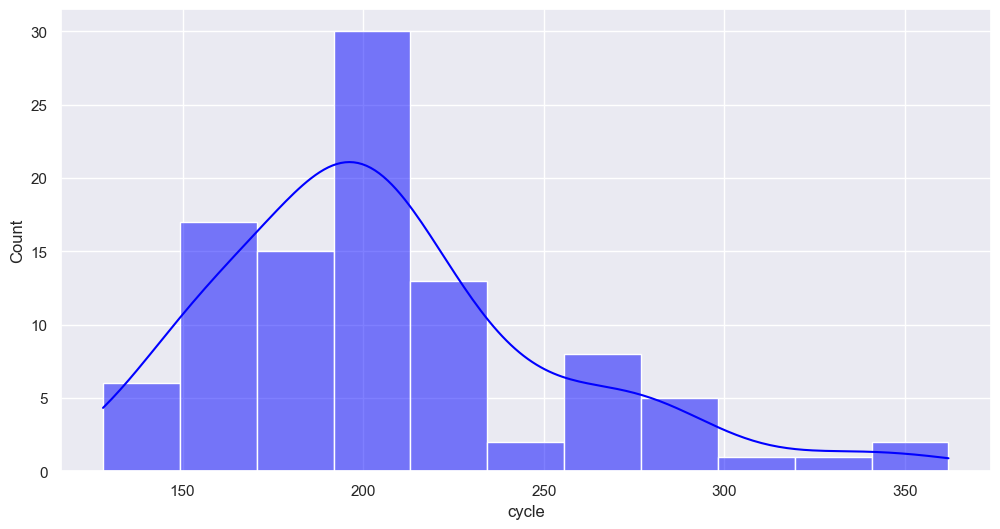

In [12]:
# Determining mean number of cycles and histogram of number of cycle

plt.subplots(figsize=(12, 6))
sns.histplot(jet_id_and_rul["cycle"], kde = True, color='blue');
print("Mean number of cycles after which jet engine fails is "+ str(math.floor(jet_id_and_rul["cycle"].mean())))

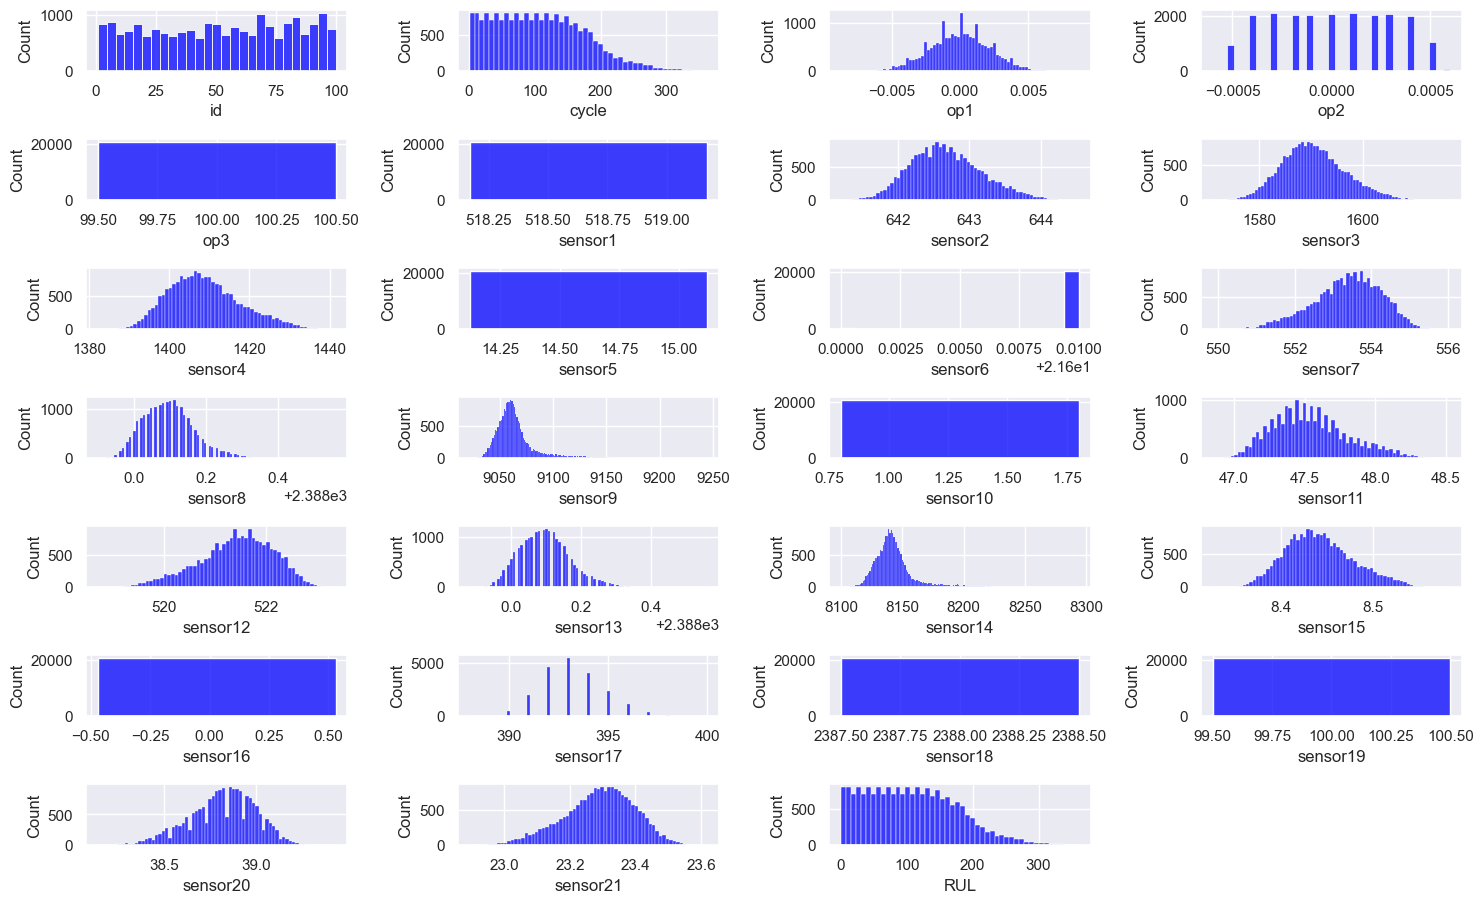

In [13]:
#Histogram representation of each sensor data

sns.set()
fig = plt.figure(figsize = [15,10])
cols = jet_data.columns
cnt = 1
for col in cols :
    plt.subplot(8,4,cnt)
    sns.histplot(jet_data[col],color='blue')
    cnt+=1
plt.tight_layout()
plt.show() 

As we could see there are many sensor data which aren't following the normal distribution, we will tend to ignore those sensors for our model training. We would try to reduce the curse of dimensionality by doing so. 

# **Correlation Matrix**

To see wheather the selected attributes are not related to each other. This way we will be able to reduce some more attributes, making our model free from overfitting. 

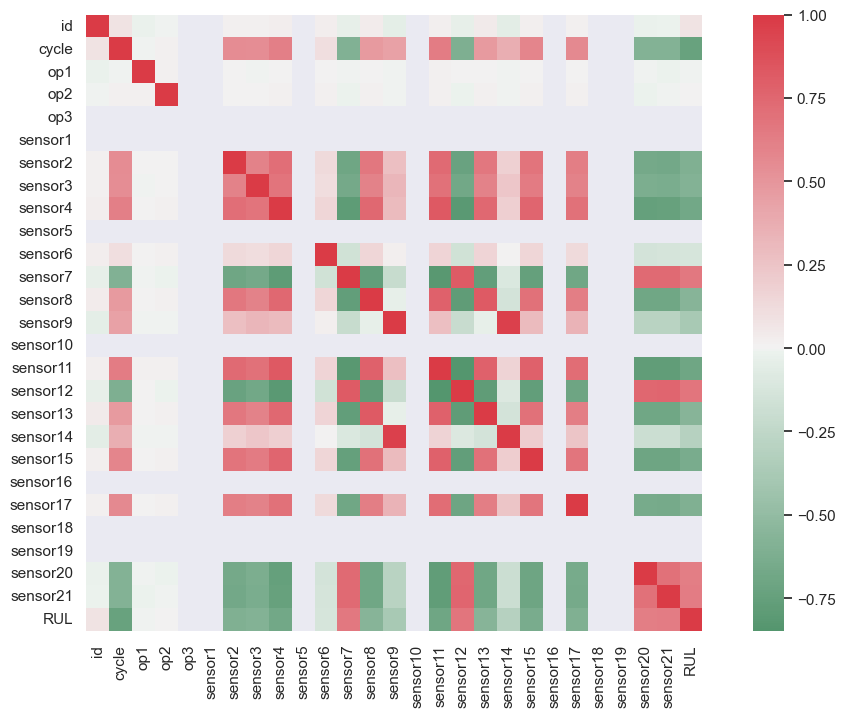

In [14]:
#Creating a heatmap to compare with RUL

plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap =cmap, center=0, annot=False, square=True);

# Deletion of non contributing parameters into the analysis

Using the above correlation heatmap, We can safely ignore the parameters with lesser correlation with RUL. we can infer that the following parameters are not related to the RUL. 
* id, op1, op2, op3
* sensor1, sensor5, sensor6, sensor10
* sensor16, sensor18, sensor19

In [15]:
#New Dataframe with relevant parameters

jet_relevant_data = jet_data.drop(["cycle", "op1", "op2", "op3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor14", "sensor13", "sensor12", "sensor11"], axis=1)

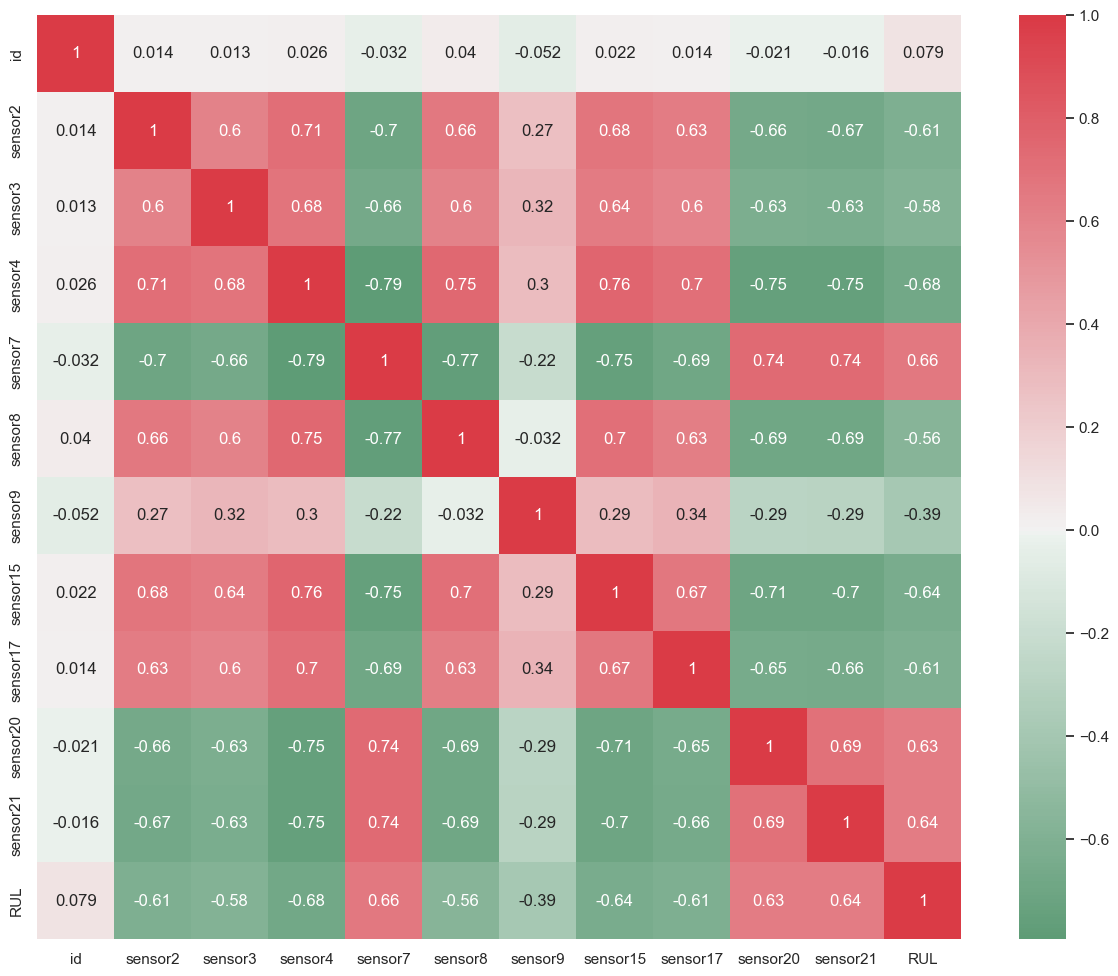

In [16]:
#Updated heatmap with relevant parameters

plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_relevant_data.corr(), cmap =cmap, center=0, annot=True, square=True);

In [17]:
def plot_sensor(sensor_name,X):
    plt.figure(figsize=(13,5))
    for i in X['id'].unique():
        if (i % 10 == 0):  # only plot every engine
            plt.plot('RUL', sensor_name, 
                     data=X[X['id']==i].rolling(8).mean())
            plt.axvline(30, color='red', linestyle='dashed', linewidth=2)
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

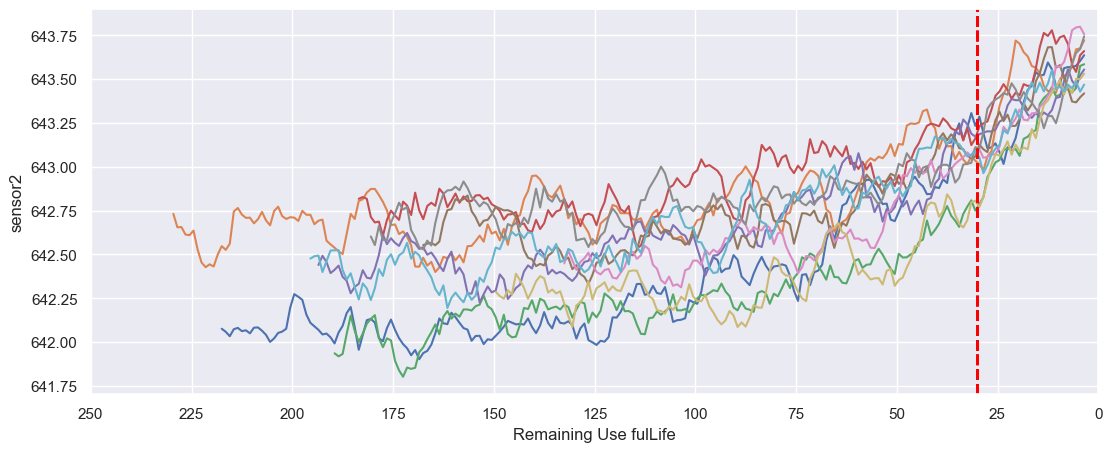

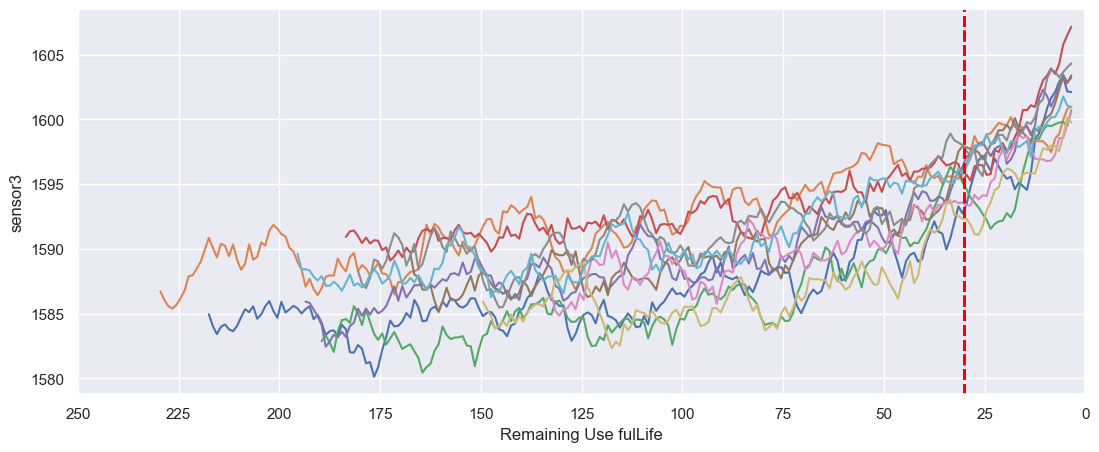

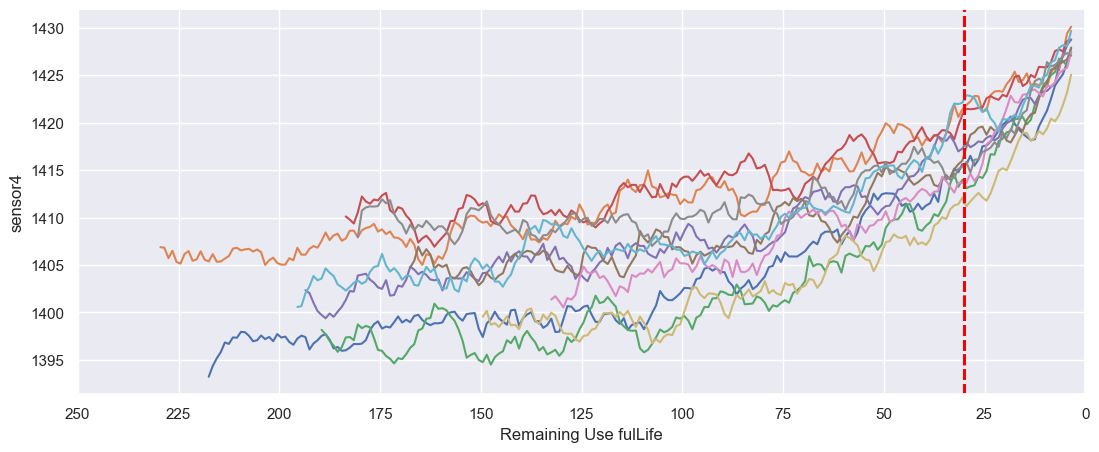

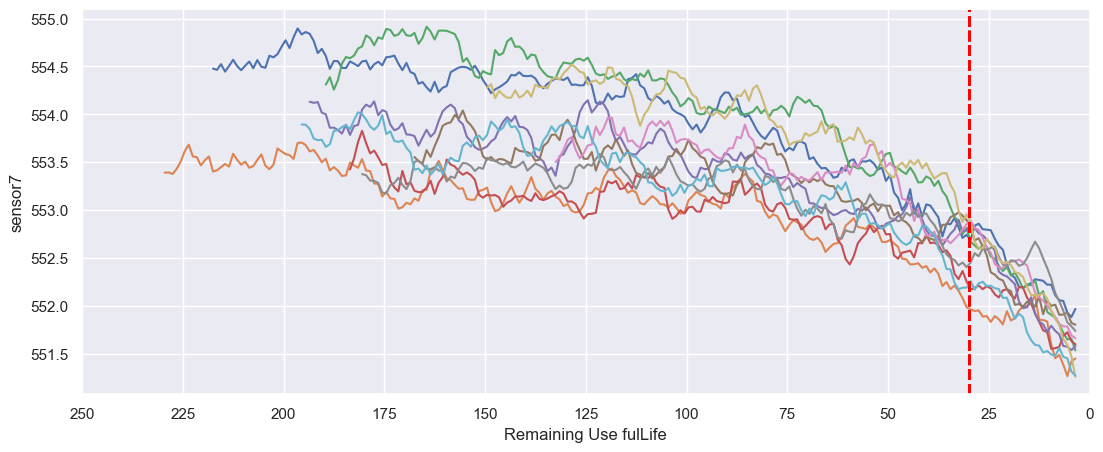

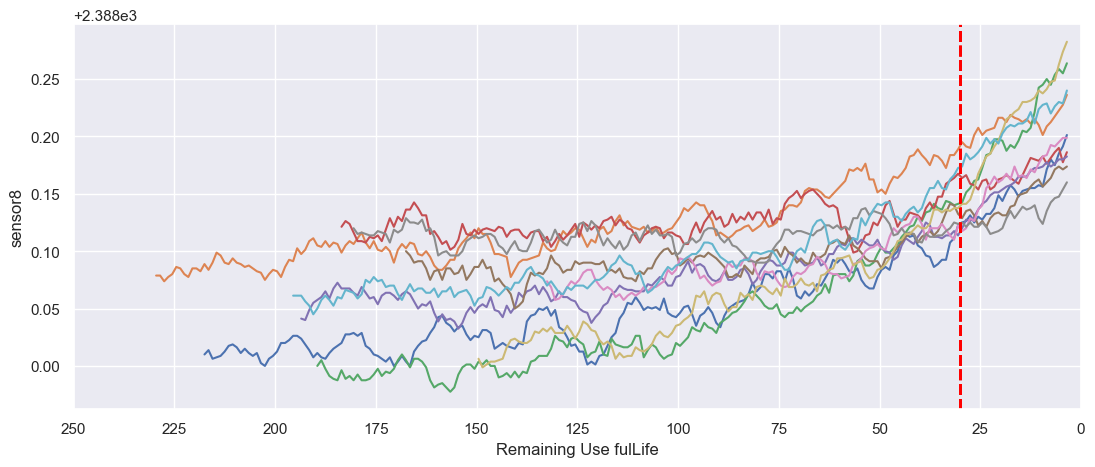

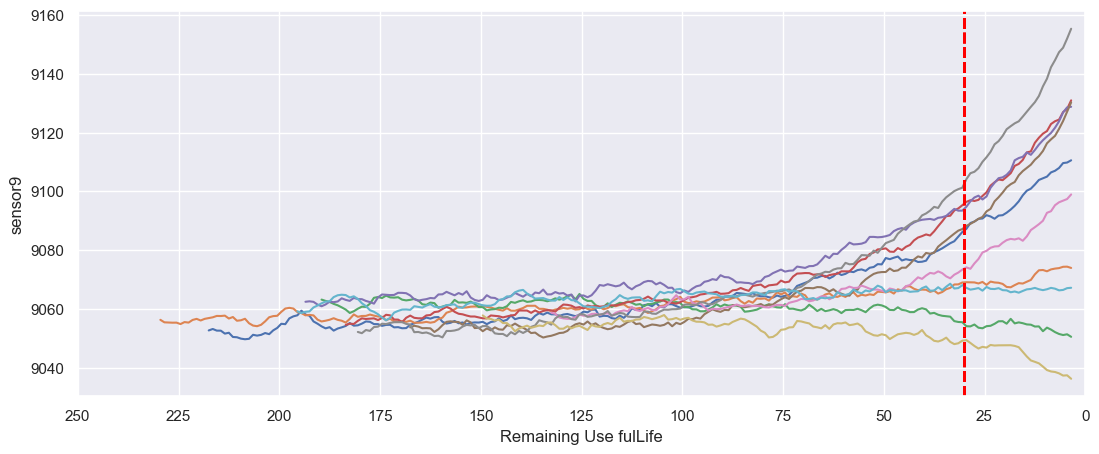

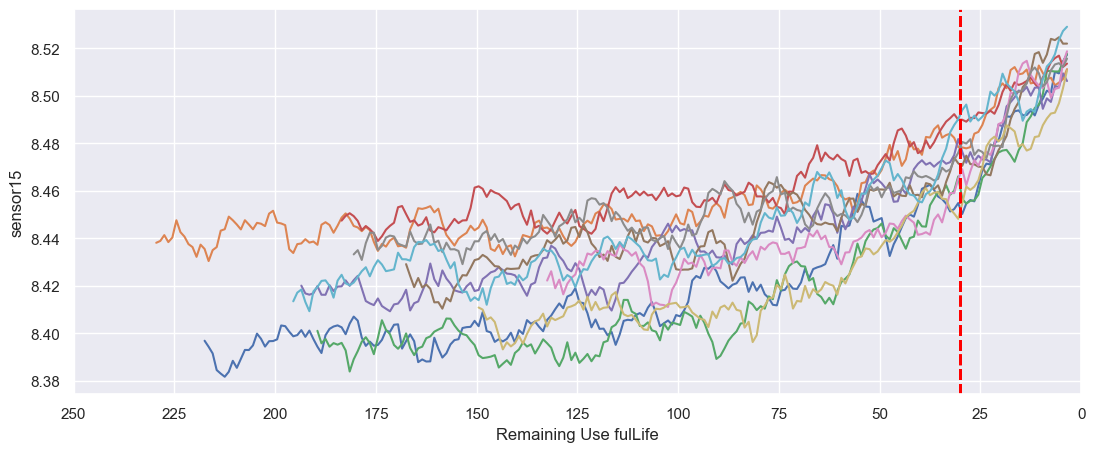

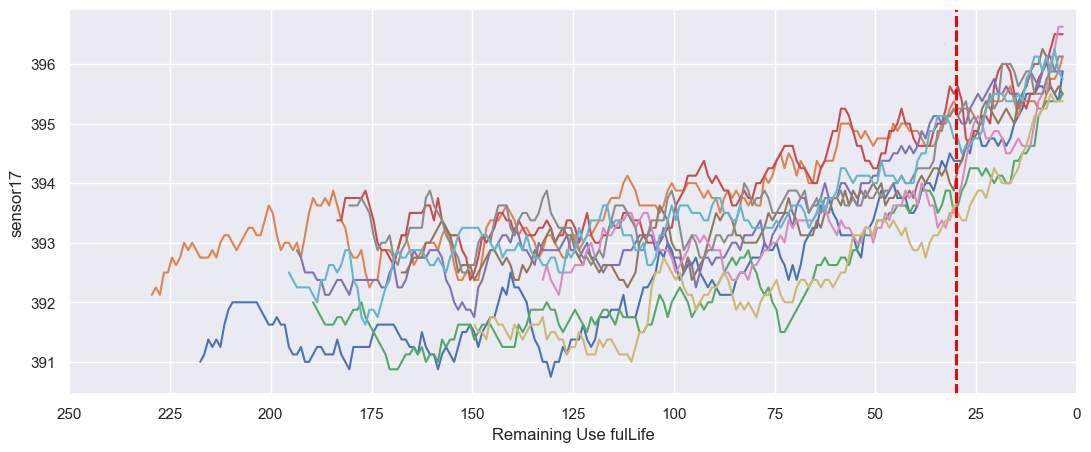

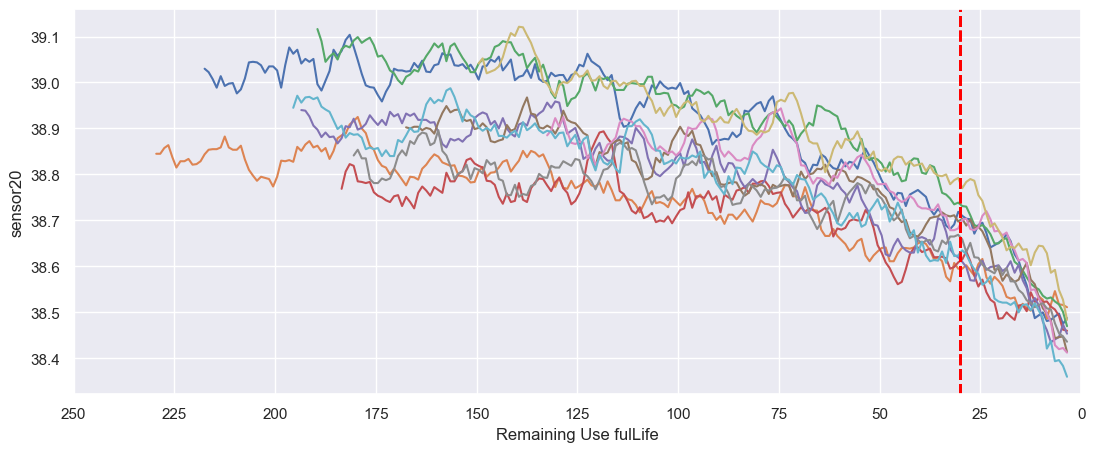

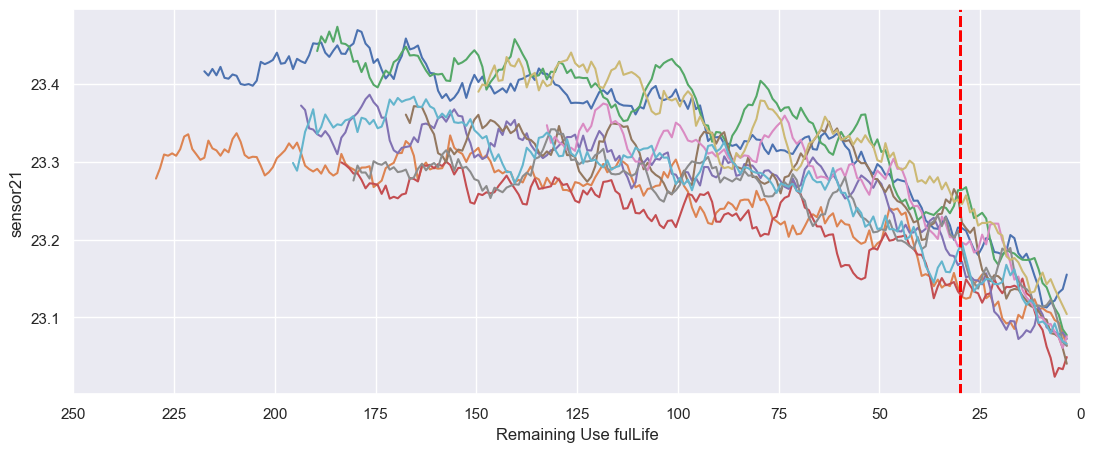

In [18]:
for sensor in jet_relevant_data.drop(['id', 'RUL'], axis=1).columns:
    plot_sensor(sensor, jet_relevant_data)

In [19]:
# Based on the above data variation, we removed sensor 9
jet_relevant_data.drop('sensor9', axis=1, inplace=True)

In [20]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(jet_relevant_data.drop(['id', 'RUL'], axis=1))
scaled_features = pd.DataFrame(scaled_features, columns=jet_relevant_data.drop(['id', 'RUL'], axis=1).columns)

In [21]:
scaled_features['id'] = jet_relevant_data['id']
scaled_features['RUL'] = jet_relevant_data['RUL']

In [22]:
# test_data_unscaled = test_data[jet_relevant_data.drop(['id', 'RUL'], axis=1).columns]

In [23]:
# test_data_unscaled.head()

In [24]:
# test_data_scaled = scaler.fit_transform(test_data_unscaled)
# test_data_scaled = pd.DataFrame(test_data_scaled, columns=jet_relevant_data.drop(['id', 'RUL'], axis=1).columns)

In [25]:
# test_data_scaled.head()

In [26]:
# test_data_scaled["id"] = test_data["id"]
# test_data_scaled["cycle"] = test_data["cycle"]

In [27]:
scaled_features.head()

sensor2   sensor3   sensor4   sensor7   sensor8  sensor15  sensor17  \
0  0.183735  0.406802  0.309757  0.726248  0.242424  0.363986  0.333333   
1  0.283133  0.453019  0.352633  0.628019  0.212121  0.411312  0.333333   
2  0.343373  0.369523  0.370527  0.710145  0.272727  0.357445  0.166667   
3  0.343373  0.256159  0.331195  0.740741  0.318182  0.166603  0.333333   
4  0.349398  0.257467  0.404625  0.668277  0.242424  0.402078  0.416667   

   sensor20  sensor21  id  RUL  
0  0.713178  0.724662   1  191  
1  0.666667  0.731014   1  190  
2  0.627907  0.621375   1  189  
3  0.573643  0.662386   1  188  
4  0.589147  0.704502   1  187

In [43]:
y = scaled_features['RUL']
X = scaled_features.drop(['RUL'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 10)
X_test shape :  (4127, 10)
y_train shape :  (16504,)
y_test shape :  (4127,)


In [34]:
data = scaled_features.copy()

In [35]:
cycle=30
data['label'] = data['RUL'].apply(lambda x: 1 if x <= cycle else 0)

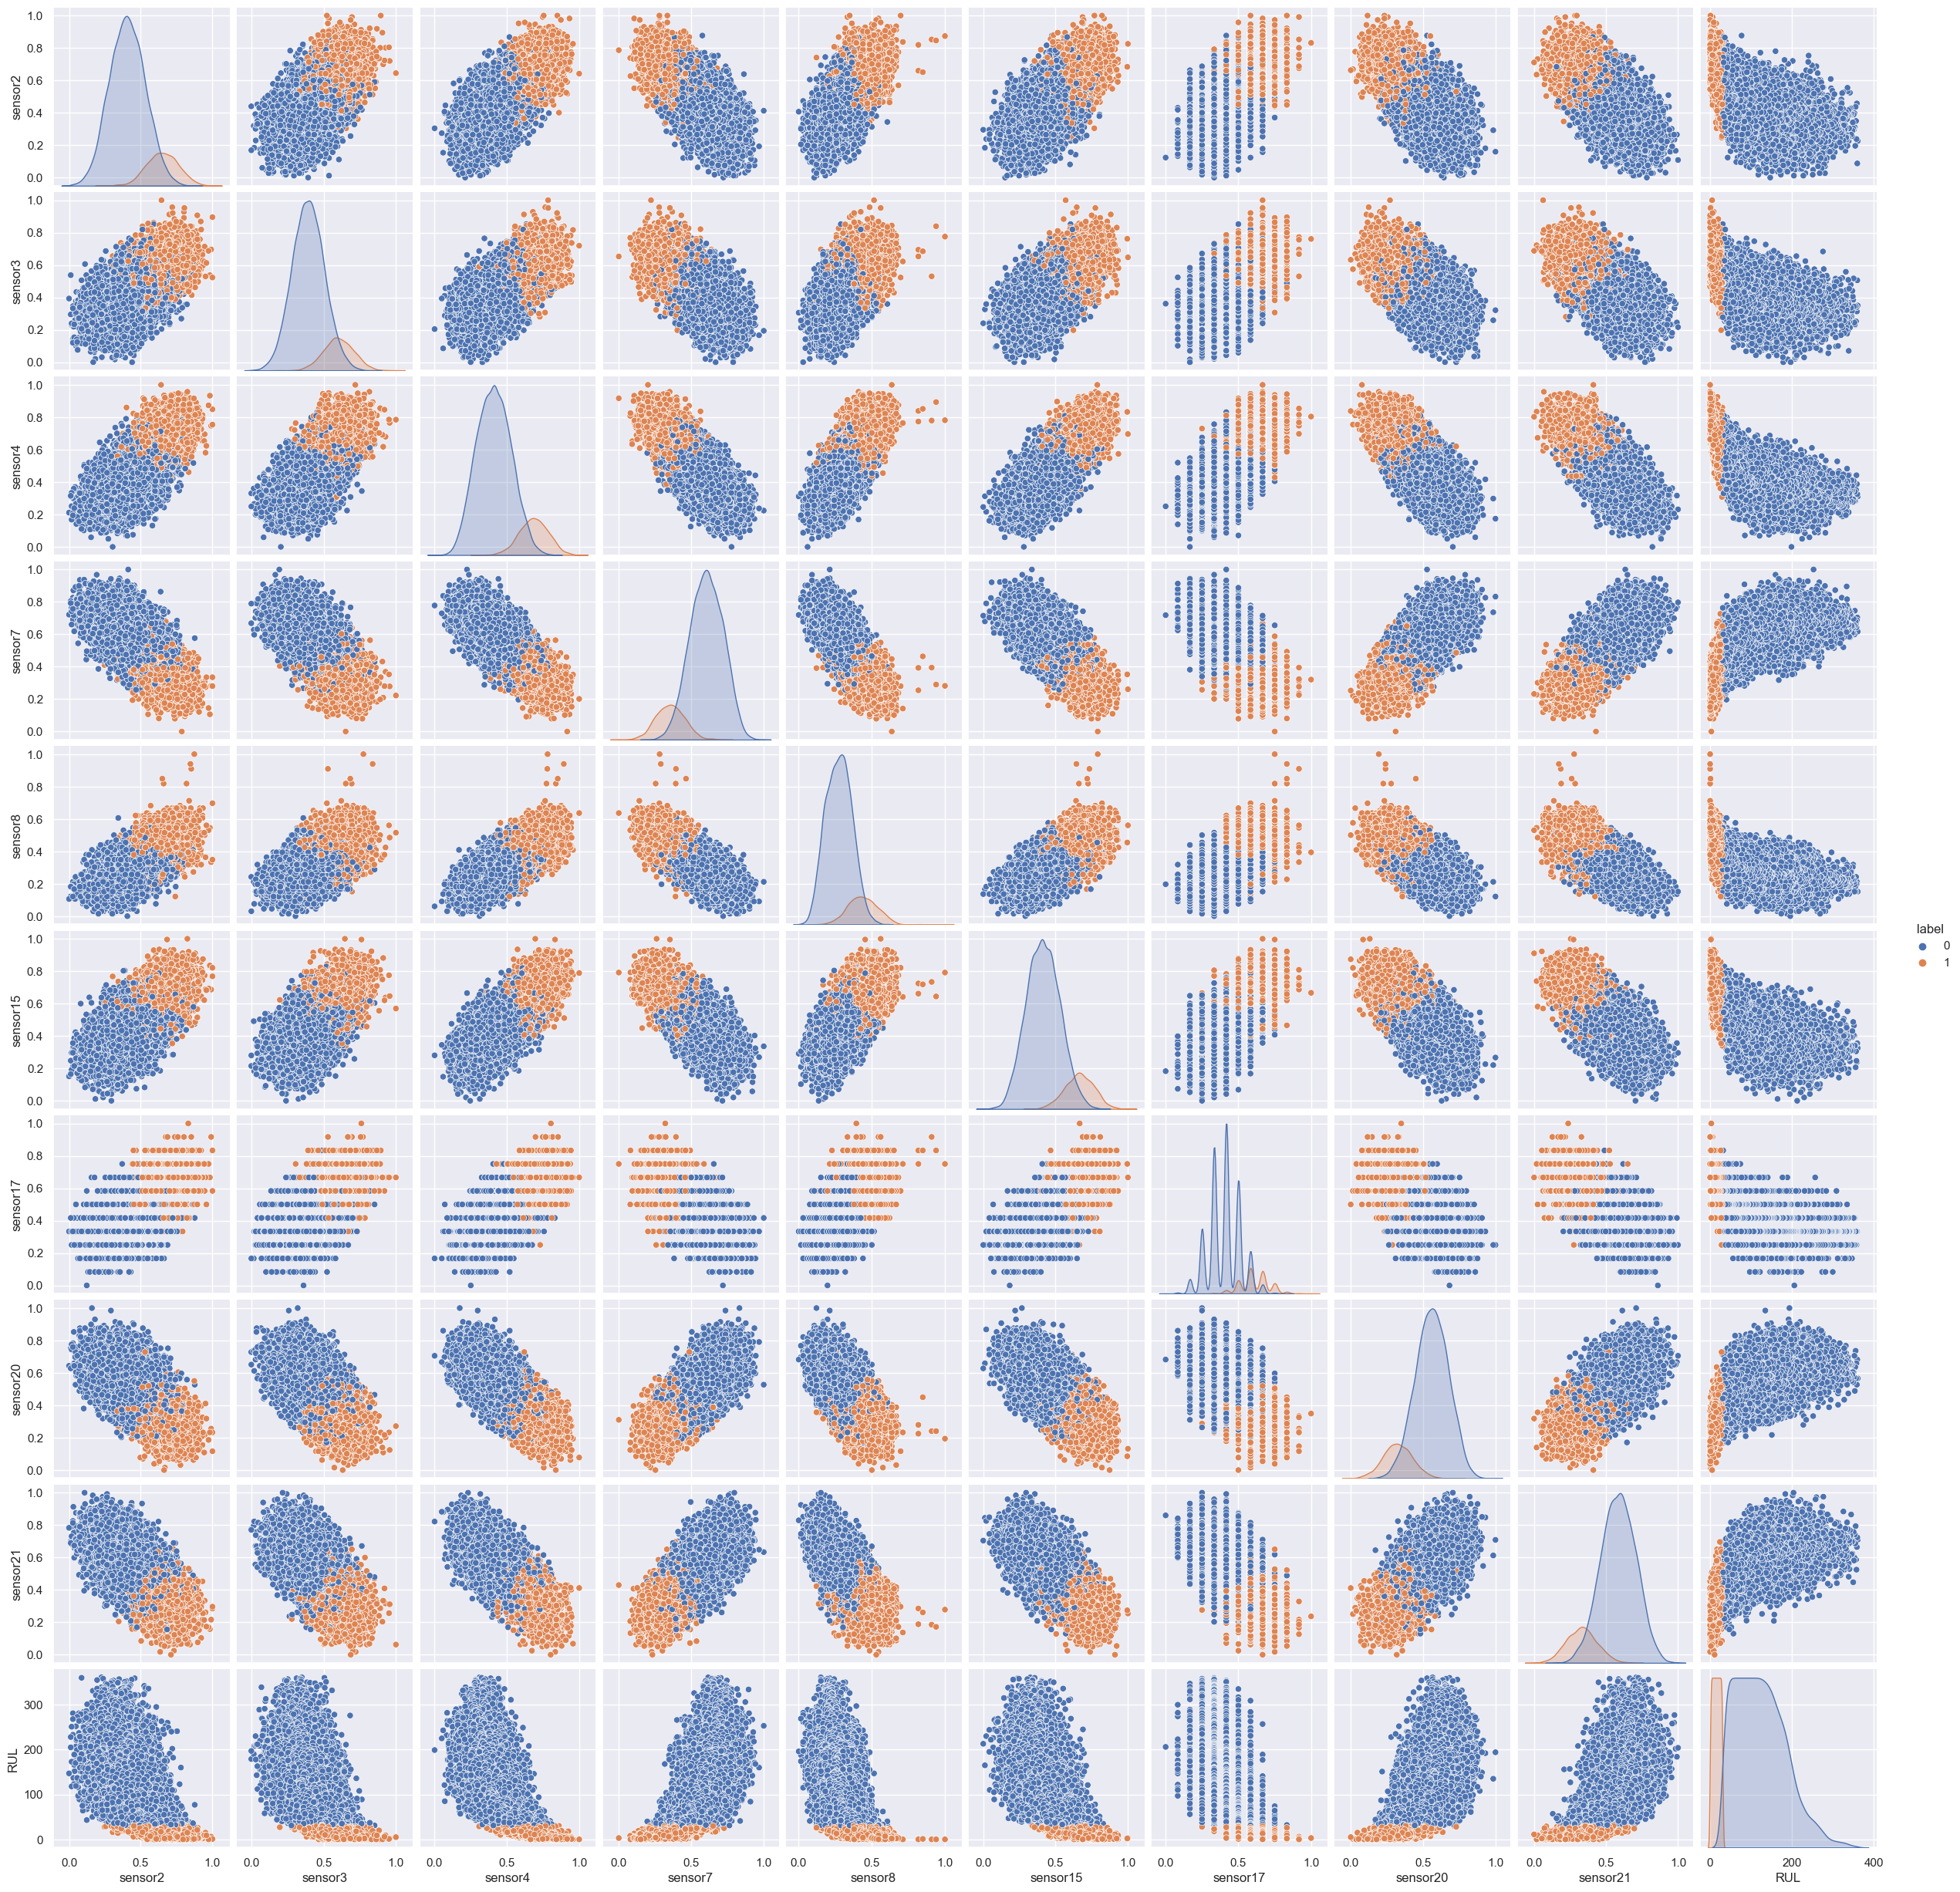

In [36]:
sns.pairplot(data.drop(['id'], axis=1), hue="label")

In [30]:
dir(results)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',

In [32]:
estimator.predict(X_test)

array([109.17629 ,  92.598335, 107.73759 , ..., 107.80245 , 107.12365 ,
        93.88631 ], dtype=float32)

In [37]:
y = data['label']
X = data.drop(['RUL', 'id', 'label'], axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 9)
X_test shape :  (4127, 9)
y_train shape :  (16504,)
y_test shape :  (4127,)


In [29]:
# Regression
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_shape=(10,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
# evaluate model
estimator = KerasRegressor(model=baseline_model, epochs=10, batch_size=5, verbose=5)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

estimator.fit(X_train, y_train ,batch_size = 32, epochs = 10,verbose=2)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
E

In [39]:
# define wider model
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_shape=(13,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [44]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

NameError: name 'Y' is not defined